In [2]:
import h5py
import os
import matplotlib.pyplot as plt
import mne 
import sklearn


# Data Analysis

In [3]:
print("Working directory:", os.getcwd())

Working directory: c:\Users\irene\Documents\irene\Università\UU\DL\Final Project data\Final Project data\DL_assignment2


In [4]:
#code snippet to read one file
def get_dataset_name(filename_with_dir):
    filename_without_dir = filename_with_dir.split('/')[-1]
    temp = filename_without_dir.split('_')[:-1]
    dataset_name = '_'.join(temp)  
    return dataset_name

filename_path = "../Cross/train/rest_164636_1.h5"


with h5py.File(filename_path, 'r') as f:
    dataset_name = get_dataset_name(filename_path)
    matrix = f.get(dataset_name)[()]
    print(type(matrix))
    print(matrix.shape)


<class 'numpy.ndarray'>
(248, 35624)


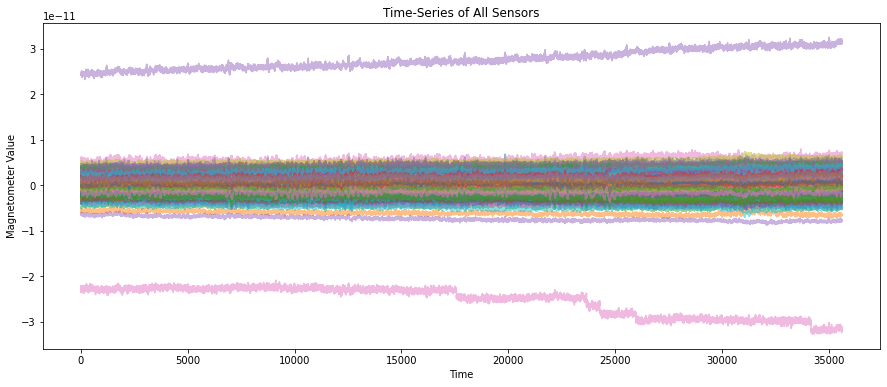

In [5]:
#plot of data points for file /Intra/train/rest_105923_1.h5
plt.figure(figsize=(15, 6))

for i in range(matrix.shape[0]):  # 248 sensors (rows)
    plt.plot(matrix[i], alpha=0.5)  # `alpha` adds transparency to avoid overlap

plt.xlabel('Time')
plt.ylabel('Magnetometer Value')
plt.title('Time-Series of All Sensors')
plt.show()


In [6]:
data_dir = '../Cross/train'

# File listing
files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]

# Preallocate lists
raws = []     # MNE Raw objects
labels = []   # Task labels

# Constants
sfreq = 2034  # Hz, number of samples per second in the signal >> for downsampling later
n_channels = 248 # channel = sensor
ch_names = [f'MEG {i:03d}' for i in range(n_channels)]
ch_types = ['mag'] * n_channels
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types) #metadata; creates MNE info object to store everything about data but actual signal values

# extract full task label (e.g., task_motor, rest)
def get_task_label(filename):
    parts = filename.split('_')
    if parts[0] == 'rest':
        return 'rest'
    elif parts[0] == 'task':
        label_parts = []
        for part in parts[1:]:
            if part.isdigit():
                break
            label_parts.append(part)
        return '_'.join(label_parts)
    else:
        return 'unknown'


# Loop through files
for fname in sorted(files):
    fpath = os.path.join(data_dir, fname)
    task_label = get_task_label(fname)

    with h5py.File(fpath, 'r') as f:
        dataset_name = get_dataset_name(fname)
        data = f[dataset_name][()]  # shape: (248, 35624)

    # Create MNE Raw object, actual MEG data
    raw = mne.io.RawArray(data, info)

    # Store
    raws.append(raw)
    labels.append(task_label)


Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623 =      0.000 ...    17.514 secs
Ready.
Creating RawArray with float64 data, n_channels=248, n_times=35624
    Range : 0 ... 35623

In [7]:
print(f"Number of recordings: {len(raws)}")
print(f"Unique tasks: {set(labels)}")
print(f"Info: {raw.info}")
data, times = raw[:, :]  # shape: (n_channels, n_times)
print("Min value:", data.min())
print("Max value:", data.max())


Number of recordings: 64
Unique tasks: {'story_math', 'rest', 'motor', 'working_memory'}
Info: <Info | 7 non-empty values
 bads: []
 ch_names: MEG 000, MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, ...
 chs: 248 Magnetometers
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1017.0 Hz
 meas_date: unspecified
 nchan: 248
 projs: []
 sfreq: 2034.0 Hz
>
Min value: -3.0254182492583936e-10
Max value: 1.5409371695307428e-11


Effective window size : 1.007 (s)
Plotting power spectral density (dB=True).


C:\Users\irene\AppData\Local\Temp/ipykernel_1252/162555123.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=125).plot(picks="data", amplitude=False)
c:\Users\irene\anaconda3\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


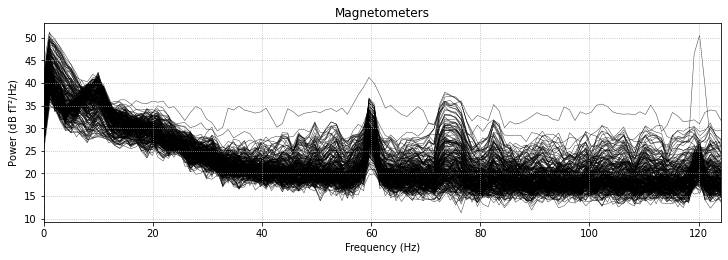

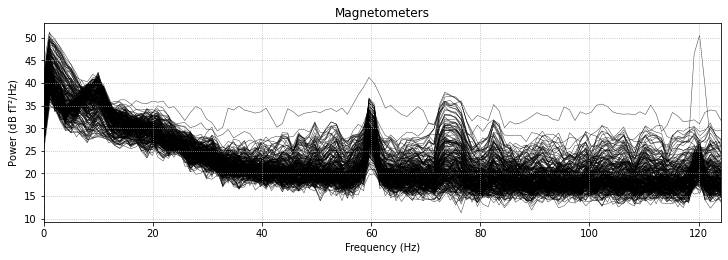

In [8]:
raw.compute_psd(fmax=125).plot(picks="data", amplitude=False)


Plotting task: rest
Using matplotlib as 2D backend.


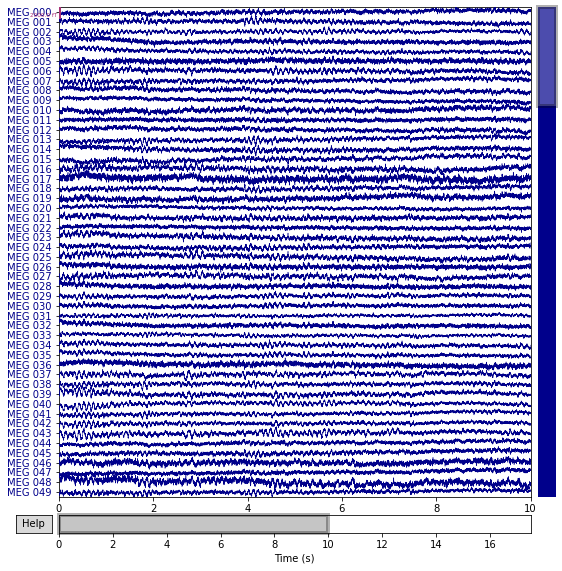

Plotting task: motor


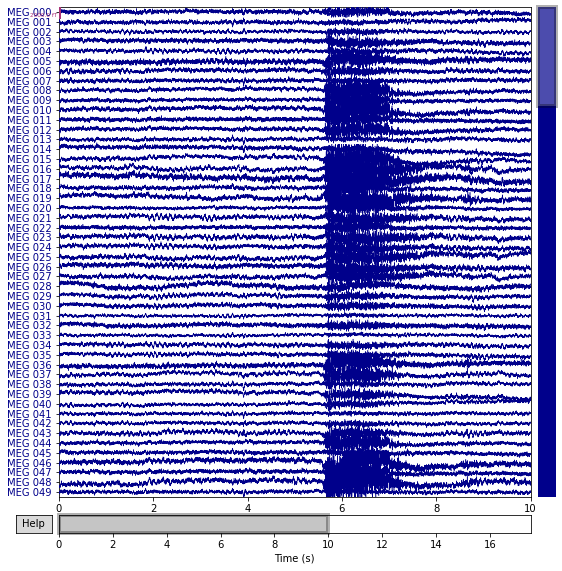

Plotting task: story_math


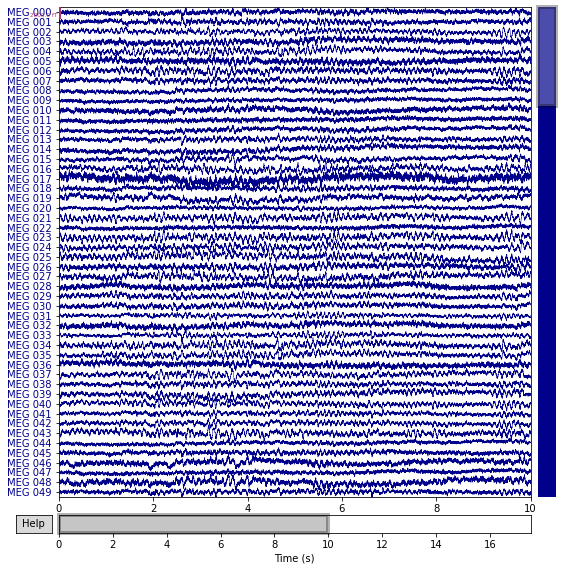

Plotting task: working_memory


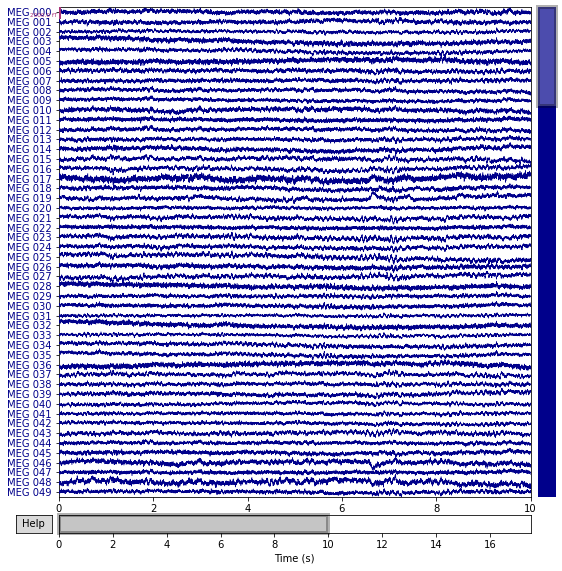

In [9]:
from collections import defaultdict

# Group raw objects by task
task_to_raws = defaultdict(list) #Auto-creates empty list as default value
for raw, label in zip(raws, labels): #Safe even if task wasn't defined yet
    task_to_raws[label].append(raw)

# Plot each task group 
for task, raw_list in task_to_raws.items():
    print(f"Plotting task: {task}")
    # First trail each task
    raw_list[0].plot(n_channels=50, title=f'Task: {task}')


# Data Preprocessing

## Data Downsampling

From 2k Hz to 250Hz. (Look Google Doc why)

In [10]:
resampled_raws = []
for raw in raws:
    raw_resampled = raw.copy().resample(250, verbose=False)
    resampled_raws.append(raw_resampled)

In [11]:
print(raw_resampled.info)

<Info | 7 non-empty values
 bads: []
 ch_names: MEG 000, MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, ...
 chs: 248 Magnetometers
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 248
 projs: []
 sfreq: 250.0 Hz
>


Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\irene\AppData\Local\Temp/ipykernel_1252/1373144648.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_resampled.compute_psd(fmax=125).plot(picks="data", amplitude=False)
c:\Users\irene\anaconda3\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


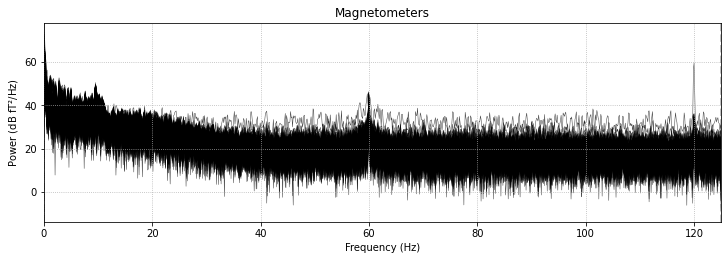

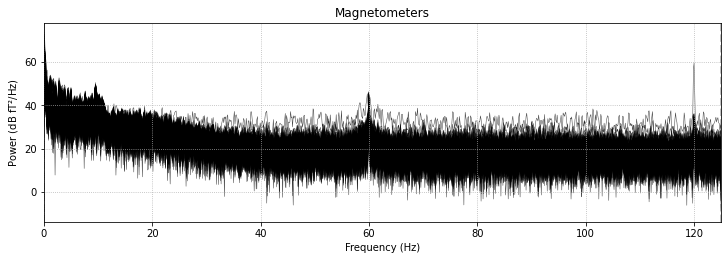

In [12]:
raw_resampled.compute_psd(fmax=125).plot(picks="data", amplitude=False)


Plotting task: rest


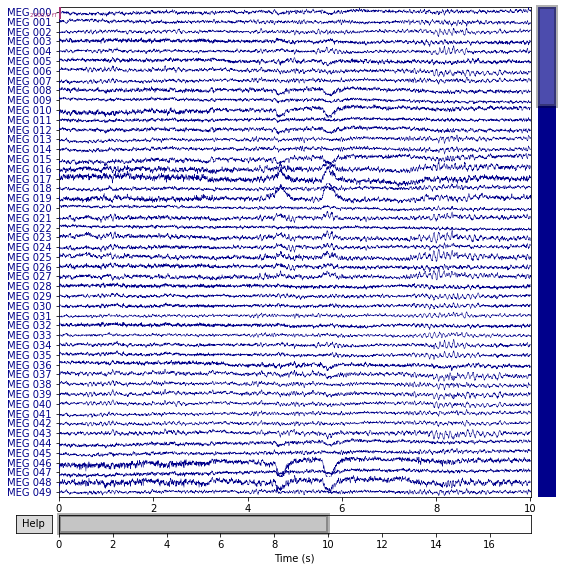

Plotting task: motor


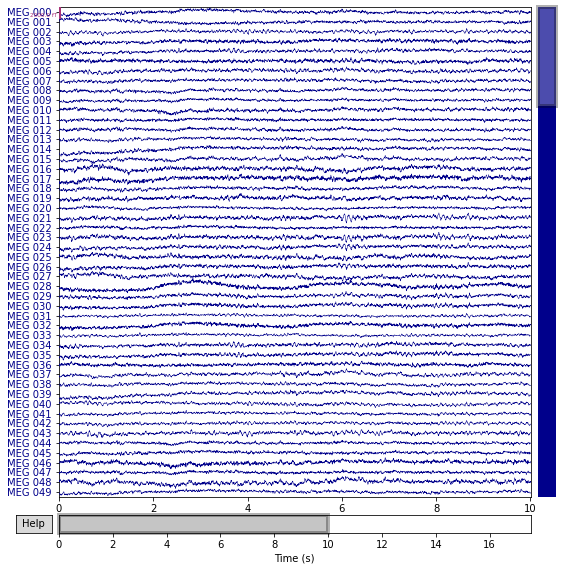

Plotting task: story_math


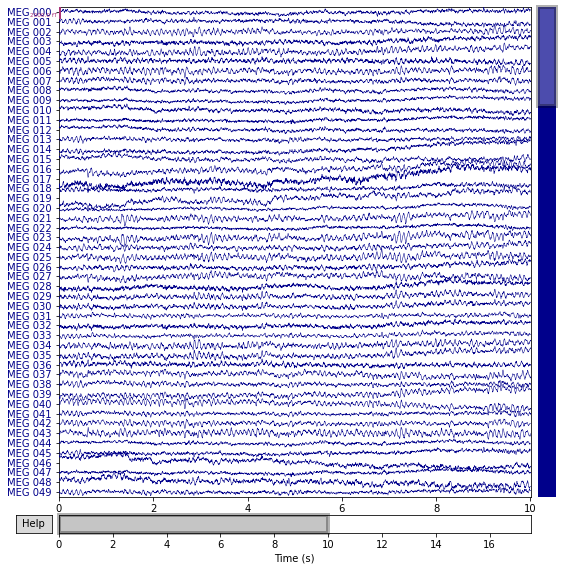

Plotting task: working_memory


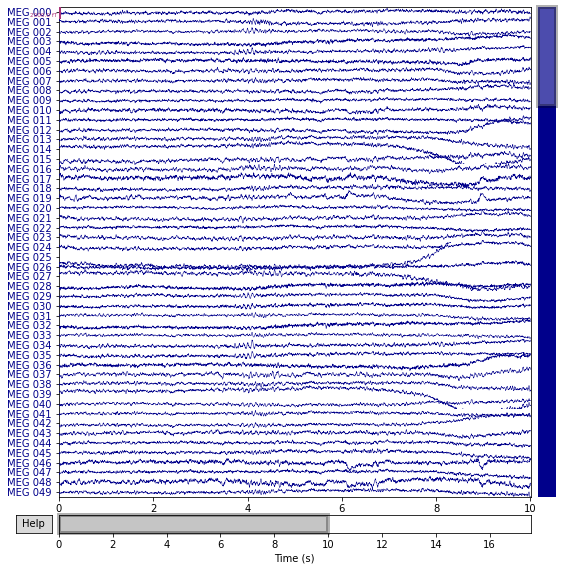

In [13]:
from collections import defaultdict

# Group resampled raw objects by task
task_to_raws = defaultdict(list)
for resampled, label in zip(resampled_raws, labels):  # <-- use resampled_raws here
    task_to_raws[label].append(resampled)

# Plot each task group
for task, raw_list in task_to_raws.items():
    print(f"Plotting task: {task}")
    # Plot the third trial (index 2) of each task if it exists
    if len(raw_list) > 2:
        raw_list[2].plot(n_channels=50, title=f'Task: {task}')


## Normalization 

In [ ]:
import numpy as np
from mne.decoding import Scaler
#every .h5 file corresponds to one trial, so one epoch of events 
# Extract data arrays and convert to femtoTesla (1 femtoTesla = 10e-15 Tesla)
data_arrays = [raw.get_data() * 1e15 for raw in resampled_raws]
#create 3D array of resampled raws
X = np.stack(data_arrays)  # shape: (n_trials, n_channels, n_times)
# to apply Z-score scaling across trials for each (channel, time) later
mean = X.mean(axis=0)  # shape: (n_channels, n_times)
std = X.std(axis=0)

In [16]:
# Group normalized resampled raw objects by task
task_to_norms = defaultdict(list)
for norm, label in zip(data_arrays, labels):
    task_to_norms[label].append(norm)


Plotting task: rest


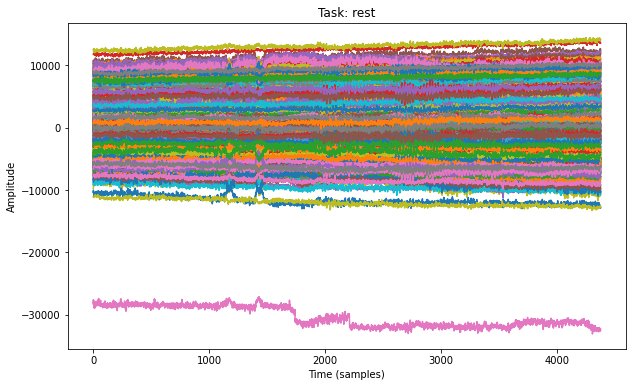

Plotting task: motor


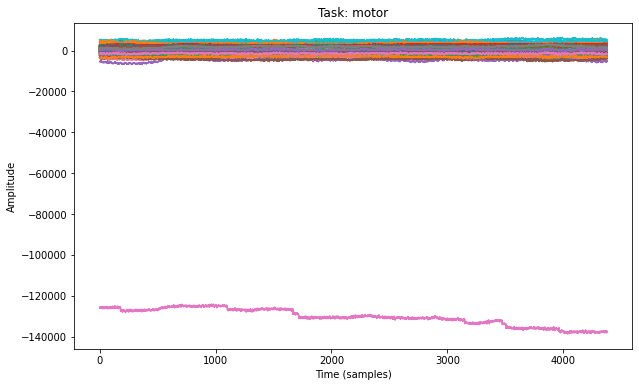

Plotting task: story_math


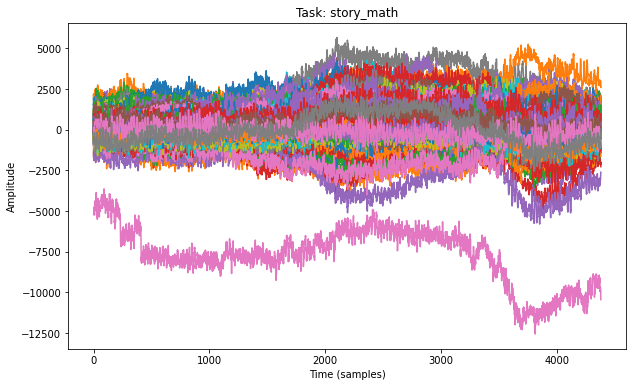

Plotting task: working_memory


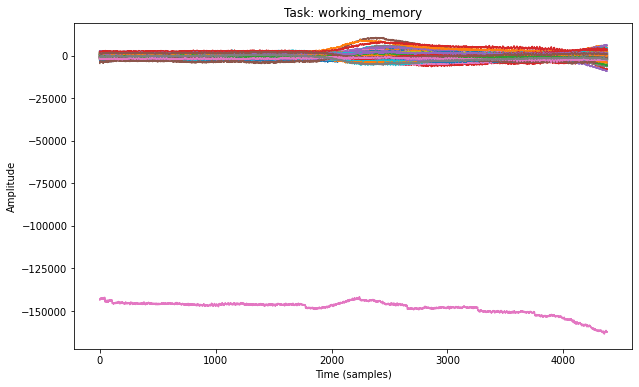

In [17]:
# Plot each task group
for task, norm_list in task_to_norms.items():
    print(f"Plotting task: {task}")
    if len(norm_list) > 2:
        data = norm_list[2]  # (n_channels, n_times)
        plt.figure(figsize=(10, 6))
        plt.plot(data.T)  # transpose to plot time on x-axis
        plt.title(f'Task: {task}')
        plt.xlabel('Time (samples)')
        plt.ylabel('Amplitude')
        plt.show()